# Unlocking the Palate - Evaluating Taste Consensus Among Beer Reviewers

---

Group [**BlackAda**](https://en.wikipedia.org/wiki/Blackadder)

> - Ludek Cizinsky ([ludek.cizinsky@epfl.ch](ludek.cizinsky@epfl.ch))
> - Peter Nutter ([peter.nutter@epfl.ch](peter@nutter@epfl.ch))
> - Pierre Lardet ([pierre.lardet@epfl.ch](pierre@lardet@epfl.ch))
> - Christopher Bastin ([christopher.bastin@epfl.ch](christian@bastin@epfl.ch))
> - Mika Senghaas ([mika.senghaas@epfl.ch](mika@senghaas@epfl.ch))

📣 Note to TA for P2 *This notebook runs a preliminary analysis on a subset of 10.000 reviews for computational efficiency. We attempt to show the feasibility and correctness of implementation for the entire pipeline. Running the analysis on the full dataset requires only to unset the `SUBSAMPLE` flag.**

## Introduction

---

Navigating the world of beer reviews can be a daunting task for non-experts. Beer aficionados often describe brews as having nuanced flavors such as "grassy notes" and "biscuity/ crackery malt," with hints of "hay." But do these descriptions reflect the actual tasting experience? Following a "wisdom-of-the-crowd" approach, a descriptor can be considered meaningful if many, independent reviewers use similar descriptors for a beer's taste. To quantify consensus, we use natural language processing techniques to extract descriptors of a beer's taste and numerically represent these descriptors to compute similarity or consensus scores. The consensus scores between beer reviews will unveil whether there is a shared understanding of taste among beer geeks.

## Dependencies

---

We load the dependencies required for this project to run.

In [1]:
# Enable continuous module reloading
%load_ext autoreload
%autoreload 1
%aimport src

# Standard library
import os

# External library
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import spacy

# Custom modules
from src import utils
from src import extractors
from src import embedders
from src import consensus
from src import pipeline

And set some global variables.

In [2]:
# Plotting settings
colorstyle = "RdBu"
sns.set_style('dark')
sns.set_palette(colorstyle)

# Pandas settings
pd.options.display.max_colwidth = 150 

# 
nlp = spacy.load("en_core_web_sm")

# URL for the full dataset
DATA_URL = "https://drive.google.com/u/2/uc?id=1IqcAJtYrDB1j40rBY5M-PGp6KNX-E3xq&export=download"

# Subsetting options
SUBSET = True
NUM_SUBSET_SAMPLES = 10_000

# Paths
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data")

# Random seed
SEED = 42

# Ensure data directory exists
os.makedirs(DATA_DIR, exist_ok=True)

## Data

---

We will be working with the beer review data from the [BeerAdvocate](https://www.beeradvocate.com/) platform. 


### Data Download

Due to its size (uncompressed 1.6 GB), the dataset is not included in the repository but must be downloaded. The course staff has provided the data via Google Drive. On the first run of this notebook, we download the compressed data file from Google Drive and extract it to the `data` folder. The compressed file is ~1.5 GB in size. 

After extraction and the removal of unnecessary files (archives, ratings file, ...), the data folder should contain the following files: `beers.csv`, `breweries.csv`, `users.csv`, `reviews.txt`. The total size of the data is ~2.9 GB.

*NB: Data loading takes around **~8min** on the first run. Subsequent runs of this cell are instant.*

In [3]:
# Download the BeerAdvocate dataset if it doesn't exist
if not os.path.exists(os.path.join(DATA_DIR, "reviews.txt")):
    utils.download_data(DATA_URL, data_dir=DATA_DIR)
print(f"Beer reviews downloaded to {DATA_DIR} ✅.")

Beer reviews downloaded to /Users/jonas-mika/epfl/coursework/projects/ada-2023-project-blackada/data ✅.


### Data Loading

Next, we load the data into a Pandas DataFrame. On the first run, we load all the reviews from the `reviews.txt` file and populate it with some additional meta-data from the other files. We then save the DataFrame to a `.feather` file for faster loading in the future. On subsequent runs, we load the DataFrame from the `.feather` file if it exists.

*NB: Running this cell for the first time reads in all `2.5M` reviews which takes **~7min**. Subsequent runs should be much faster, taking about **~1min**.*

In [4]:
# Load all reviews and a subset of reviews (100,000)
if SUBSET:
    reviews = utils.load_data(DATA_DIR, num_samples=NUM_SUBSET_SAMPLES, seed=SEED)
else:
    reviews = utils.load_data(DATA_DIR, seed=SEED)

msg = "Subset of Data" if SUBSET else "Full Data"
print(f"Loaded {len(reviews)} reviews ✅. ({msg})")

Loaded 10000 reviews ✅. (Subset of Data)


### Sanity Checks

During the data loading (`utils.load_data`) we perform some basic data pre-processing and merging. Specifically, we do the following:
- Merge the reviews data with some additional meta-data about the beers, users and breweries (e.g. beer style, user location, ...) and collect in a singe multi-column DataFrame.
- We cast each column to the correct type, e.g. `date` is converted to a `datetime` object.
- We remove any reviews with any missing values (as there are only very few where this is the case)

We check that each of these steps is performed correctly and that the data is consistent.

In [5]:
# Check that additional information is loaded in the reviews
additional_cols = [("user", "location")]

for col in additional_cols:
    err_msg = f"❌ Additional column {col} not loaded."
    assert col in reviews.columns, err_msg
print(f"✅ Additional columns loaded.")

✅ Additional columns loaded.


In [6]:
# Check that columns have correct type (e.g. review time is a datetime)
example_types = {("review", "date"): "datetime64[ns]", ("review", "rating"): "float64", ("review", "text"): "object"}

for col, dtype in example_types.items():
    err_msg = f"❌ Column has type {reviews[col].dtype} but should be {dtype}"
    assert reviews[col].dtype == dtype, err_msg
print(f"✅ All columns have correct type.")

✅ All columns have correct type.


In [7]:
# Check that there are no missing values (NaNs)
missing_values = reviews.isna().sum()

err_msg = f"❌ There are {missing_values.sum()} missing values in the dataset!"
assert missing_values.sum() == 0, err_msg
print(f"✅ There are no missing values.")

✅ There are no missing values.


### Understanding the Data

Let's explore the data a bit. In this section we will investigate the total number of reviews and in various sub-groups, as well as understand basic statistics about the textual reviews.

*Note: We have a full notebook with more detailed EDA of the data in the [`playground/eda.ipynb`](https://github.com/epfl-ada/ada-2023-project-blackada/blob/main/playground/eda.ipynb) notebook. In this notebook we focus on the parts of the data exploration that are important for our project.*

In [8]:
# Show the first 5 rows of the data
reviews.head(3)

beer                                                                \
       id           name             style  abv nbr_ratings nbr_reviews   
0  142544          Régab   Euro Pale Lager  4.5           1           1   
1   19590  Barelegs Brew  English Pale Ale  4.5           4           4   
2   19590  Barelegs Brew  English Pale Ale  4.5           4           4   

  brewery                                                               \
       id                                       name          location   
0   37262  Societe des Brasseries du Gabon (SOBRAGA)             Gabon   
1   10093       Strangford Lough Brewing Company Ltd  Northern Ireland   
2   10093       Strangford Lough Brewing Company Ltd  Northern Ireland   

             ...                user                                review  \
  nbr_beers  ...              joined                   location appearance   
0         1  ... 2008-01-07 11:00:00  United States, Washington       3.25   
1         5  ... 2007-10-08 10:00:00    United States, New York       3.00   
2         5  ... 2005-05-18 10:00:00           Northern Ireland       4.00   

                                     \
  aroma palate taste overall rating   
0  2.75   3.25  2.75     3.0   2.88   
1  3.50   3.50  4.00     3.5   3.67   
2  3.50   3.50  4.00     3.5   3.73   

                                                                                                                                                          \
                                                                                                                                                    text   
0  From a bottle, pours a piss yellow color with a fizzy white head.  This is carbonated similar to soda.The nose is basic.. malt, corn, a little flo...   
1  Pours pale copper with a thin head that quickly goes. Caramel, golden syrup nose. Taste is big toasty, grassy hops backed by dark fruit, candy cor...   
2  500ml Bottle bought from The Vintage, Antrim...Poured a golden yellow / orange colour... White head poured quite thick and foamy and faded to thin...   

                       
                 date  
0 2015-08-20 10:00:00  
1 2009-02-20 11:00:00  
2 2006-03-13 11:00:00  

[3 rows x 24 columns]

We see that all data is in a single data frame with multi-column indexing. Each row corresponds to a single review of a beer and denotes the user (`user`), beer (`beer`) and brewery (`brewery`) meta information, as well as the actual review data (`review`) in separate column indices. For example, we can look at the keys individually for the first three reviews.

In [9]:
# Meta-information on beer for first 3 samples
reviews["beer"].head(3)

,id,name,style,abv,nbr_ratings,nbr_reviews
0,142544,Régab,Euro Pale Lager,4.5,1,1
1,19590,Barelegs Brew,English Pale Ale,4.5,4,4
2,19590,Barelegs Brew,English Pale Ale,4.5,4,4


In [10]:
# Meta-information on user for first 3 samples
reviews["user"].head(3)

,id,name,nbr_ratings,nbr_reviews,joined,location
0,nmann08.184925,nmann08,7820,465,2008-01-07 11:00:00,"United States, Washington"
1,stjamesgate.163714,StJamesGate,2521,2504,2007-10-08 10:00:00,"United States, New York"
2,mdagnew.19527,mdagnew,1797,1143,2005-05-18 10:00:00,Northern Ireland


In [11]:
# Meta-information on brewery for first 3 samples
reviews["brewery"].head(3)

,id,name,location,nbr_beers
0,37262,Societe des Brasseries du Gabon (SOBRAGA),Gabon,1
1,10093,Strangford Lough Brewing Company Ltd,Northern Ireland,5
2,10093,Strangford Lough Brewing Company Ltd,Northern Ireland,5


In [12]:
# Information about review for first 3 samples
reviews["review"].head(3)

,appearance,aroma,palate,taste,overall,rating,text,date
0,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with a fizzy white head. This is carbonated similar to soda.The nose is basic.. malt, corn, a little flo...",2015-08-20 10:00:00
1,3.00,3.50,3.50,4.00,3.5,3.67,"Pours pale copper with a thin head that quickly goes. Caramel, golden syrup nose. Taste is big toasty, grassy hops backed by dark fruit, candy cor...",2009-02-20 11:00:00
2,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim...Poured a golden yellow / orange colour... White head poured quite thick and foamy and faded to thin...",2006-03-13 11:00:00


As we see, for each review, we have information on the following features:
    
1. **Review** (`review`): Review Text, Ratings (Appearance, Aroma, Palate, Taste, Overall, Rating), Date
2. **User** (`user`): User ID, User Name, #Ratings, #Reviews, Joined Date, Location
3. **Beer** (`beer`): Beer ID, Beer Name, Beer Style, ABV (Alcohol By Volume), #Ratings, #Reviews
4. **Brewery** (`brewery`): Brewery ID, Brewery Name, Location, #Beers

### Groups

In our analysis we want to compute the consensus between the language used in reviews of a) all beers, b) beers of the same style, c) beers from the same brewery and, finally, d) invidual beers. The hypothesis is that the finer-grained the grouping, the higher the consensus between the reviewers. However, for the analysis to be meaningful we need to ensure that there are enough reviews in each group. We therefore compute the number of reviews in each group and plot the distribution of the number of reviews per group.

In [13]:
unique_beer_styles = reviews.beer["style"].drop_duplicates()
unique_breweries = reviews.brewery.drop_duplicates()
unique_beers = reviews.beer.drop_duplicates()

print(f"Number of unique beer styles: {len(unique_beer_styles)}")
print(f"Number of unique breweries: {len(unique_breweries)}")
print(f"Number of unique beers: {len(unique_beers)}")

Number of unique beer styles: 72
Number of unique breweries: 90
Number of unique beers: 817


We show the sorted number of reviews per beer style, brewery and beer below. The y-axis is log-scaled to better show the distribution and we add a horizontal line to show the minimum number of reviews to `100` per beer style, brewery and beer that we require for our further analysis. 

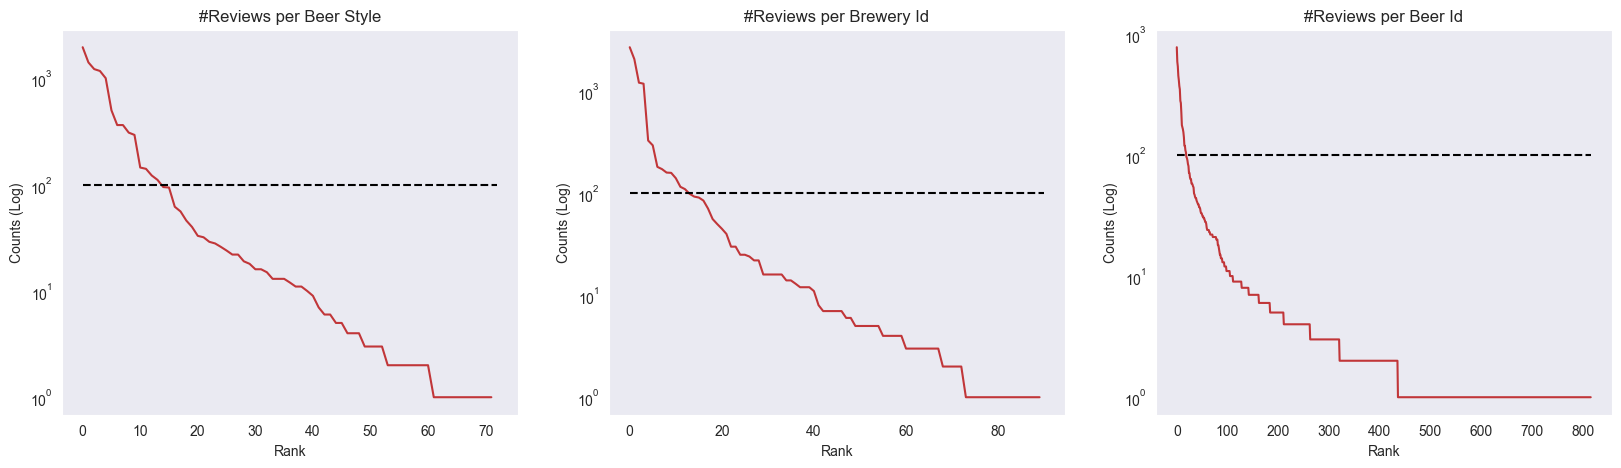

In [14]:
# Minimum number of reviews for a beer style, brewery, or beer to be included in the analysis
MIN_REVIEWS = 100

# Compute the number of reviews for each element in each group
reviews_per_beer_style = reviews.groupby(by=("beer", "style")).size().sort_values(ascending=False)
reviews_per_brewery = reviews.groupby(by=("brewery", "id")).size().sort_values(ascending=False)
reviews_per_beer = reviews.groupby(by=("beer", "id")).size().sort_values(ascending=False)

# Plot number of reviews per beer style
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, reviews_per_group in zip(axs, [reviews_per_beer_style, reviews_per_brewery, reviews_per_beer]):
    sns.lineplot(x=range(len(reviews_per_group)), y=reviews_per_group.values, ax=ax)
    ax.plot([0, len(reviews_per_group)], [MIN_REVIEWS, MIN_REVIEWS], linestyle="--", color="black")
    a, b = reviews_per_group.index.names[0]
    ax.set(
        title=f"#Reviews per {a.capitalize()} {b.capitalize()}",
        xlabel="Rank",
        ylabel="Counts (Log)",
        yscale="log"
        )
    

In [15]:
# Filter out beer styles with less than MIN_REVIEWS reviews
included_beer_styles = reviews_per_beer_style[reviews_per_beer_style >= MIN_REVIEWS].index
included_breweries = reviews_per_brewery[reviews_per_brewery >= MIN_REVIEWS].index
included_beers = reviews_per_beer[reviews_per_beer >= MIN_REVIEWS].index

# Create masks for filtering out beer styles with less than MIN_REVIEWS reviewsk
min_reviews_beer_style_mask = reviews.beer["style"].isin(included_beer_styles)
min_reviews_breweries_mask = reviews.brewery["id"].isin(included_breweries)
min_reviews_beer_mask = reviews.beer["id"].isin(included_beers)

# Filter out reviews for beer styles with less than MIN_REVIEWS reviews
original_reviews = reviews.copy()
reviews = reviews[min_reviews_beer_style_mask & min_reviews_breweries_mask & min_reviews_beer_mask]

print(f"✅ Filtering done. Reviews after filtering: {len(reviews)} (Removed {len(original_reviews) - len(reviews)} reviews)")

✅ Filtering done. Reviews after filtering: 5508 (Removed 4492 reviews)


### Reviews Statistics

The textual reviews are central to our analysis and we will be using them to extract the taste descriptors. Let's look at some statistics about the reviews to ensure that they are of good quality.

In [16]:
# Let's show some example reviews
pd.DataFrame(reviews.review.head(10)["text"])

,text
1248,"Light opaque brown pour. There's a weird tea like aroma. Like more than hops, although I'm sure the tea like notes are derivative of the earthy ..."
1249,The pour was a cloudy deep reddish brown with a 1.5-finger off-white head that dissipated quickly. The aroma was toffee with a hint of holiday fru...
1250,"Appearance: Pours a clouded body the color of fine, aged leather. Modest-sized head of large, dissipating suds.Smell: Cut hardwood planks layered ..."
1251,"Beer bottle (50 cl.), tasted in 2010.Appearance : amber color, with tan foamy head.Smell : roasted malt and caramel aromas.Taste and mouthfeel : t..."
1252,quite tastey. poured brownish into my tower glass. good carbonation. nice balance of hops and malts and gives a good biscuit bitter dry finish. th...
1254,I wish all beers came in big fat 16.9 ounce bottles. This one poured nicely into a pint glass (some left in the bottle). Dark carmel brown with sa...
1256,Big bottle poured into an English pint glass. The pour is cloudy deep reddish brown with a 1.5-finger khaki head floating atop. The aroma is caram...
1257,"This was new at my Beer store, so I got it!A- Pours dark golden with a nice head.The head is actually very impressive. S- hoppy smell also caramel..."
1258,This ESB has been showing up on shelves in SoCal beer stores over the last couple months...or I haven't noticed this beer before. I got the Guinne...
1259,"Good across the board, this is one fine drinking ale. The look is of a deep ruby dark amber almost to mahogany in shading. A small cream colored a..."


We see that this random sample of 10 reviews consists only of reviews that are very detailed and descriptive about the beer and its taste. This suggests that the majority of reviews are of good quality and suited for our analysis. However, we suspect that there might be some meaningless "spam" reviews that may skew our results. We will investigate this by checking for outliers in the review length. We use simple proxies for review length, namely the number of words and characters in the review.

,count,mean,std,min,25%,50%,75%,max
Character Lengths,5508.0,705.702796,408.509738,137.0,436.0,610.0,859.0,4458.0
Word Lengths,5508.0,123.406500,72.576827,15.0,75.0,106.0,151.0,786.0


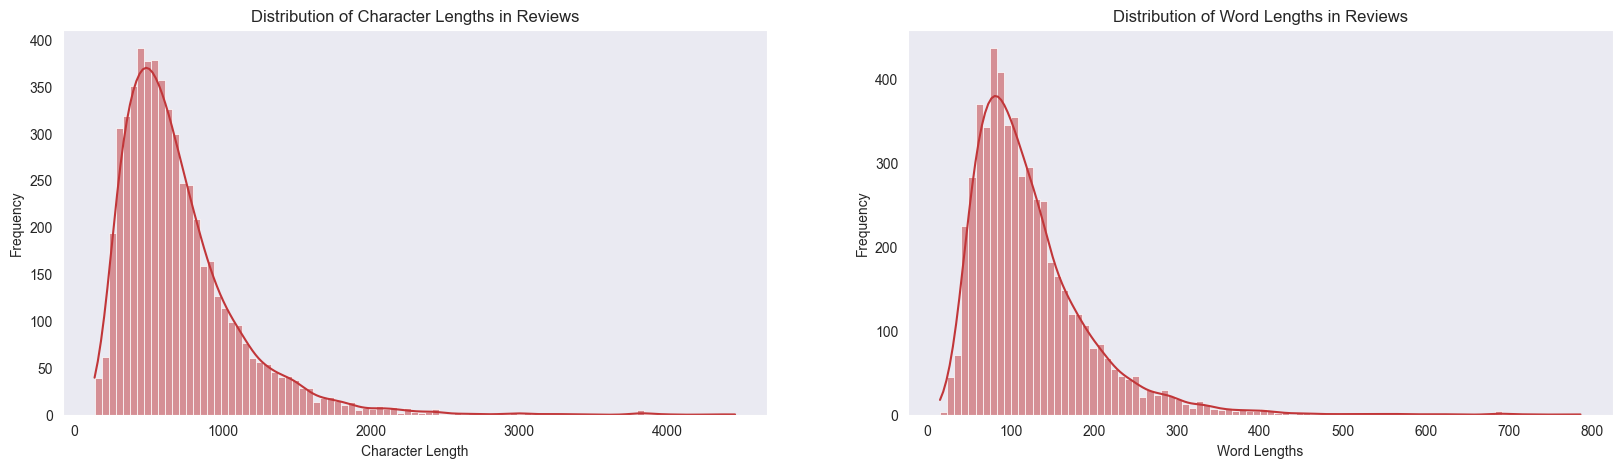

In [17]:
# Compute character and word lengths of reviews
character_lengths = reviews.review.text.str.len()
word_lengths = reviews.review.text.apply(lambda x: len(x.split()))

# Distribution of the number of ratings/ reviews per user
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
sns.histplot(x=character_lengths, kde=True, ax=ax[0])
sns.histplot(x=word_lengths, kde=True, ax=ax[1])

character_lengths_stats = character_lengths.describe()
word_lengths_stats = word_lengths.describe()

ax[0].set(
    title="Distribution of Character Lengths in Reviews",
    xlabel="Character Length",
    ylabel="Frequency",
)
ax[1].set(
    title="Distribution of Word Lengths in Reviews",
    xlabel="Word Lengths",
    ylabel="Frequency",
)

# Show summary statistics
pd.DataFrame([character_lengths_stats, word_lengths_stats], index=["Character Lengths", "Word Lengths"])

We see that most reviews are around **~408 characters** and **~123 words** long. There is a slight right-skew in the distribution, meaning that there are some very long reviews. The very short reviews are probably not very helpful for our analysis as the numeric representation will not be meaningful. Let's look at those reviews to see if further processing is required.

In [18]:
# Show the shortest 0.1% of reviews (by character count)
n = int(len(reviews) * 0.001)
character_sorted = list(character_lengths.sort_values().index.values)
shortest_character_length_reviews = reviews.review[reviews.index.isin(character_sorted[:n])]

pd.DataFrame(shortest_character_length_reviews.text)

,text
1944,"**12/24/2016Bottle to snifter.Dark black, no head...right to lacing.Toasty barleyLight fruit finishA little Smokey. From the scotch, **"
2778,Black and blacker.Prunes and figs.Hint of chocolate. Some oak with a touch of Scotch. Light peat. Subtle.Mild and long. Sweet but not sticky.Excel...
5436,"Tasted at bustling Apeldoorn; Beautiful dark gold with a fairly firm foam suit, floral aroma, a lot of co2 therefore soapy and remains only floral..."
7679,"Can pour, one finger head. Typical pale lager look. Decent taste going down but an unpleasant aftertaste. There are much better pale lagers than..."
7764,Another beer that tastes like Heineken but a little worse. Nothing really good or bad stands out about this Lager. Typical skunkiness can be expec...


In [19]:
# Show the shortest 0.1% of reviews (by word count)
n = int(len(reviews) * 0.001)
words_sorted = list(word_lengths.sort_values().index.values)
shortest_word_length_reviews = reviews.review[reviews.index.isin(words_sorted[:n])]

pd.DataFrame(shortest_word_length_reviews.text)

,text
1944,"**12/24/2016Bottle to snifter.Dark black, no head...right to lacing.Toasty barleyLight fruit finishA little Smokey. From the scotch, **"
2319,Light brown appearance with little head but just the right amount of carbonation. Complex aroma with a slight nutty coffee hint. Excellent nutty...
2778,Black and blacker.Prunes and figs.Hint of chocolate. Some oak with a touch of Scotch. Light peat. Subtle.Mild and long. Sweet but not sticky.Excel...
3863,"A very good beer, with pleasant but not overbearing aromas of coffee and burnt bread. Very drinkable despite the lingering roasty aftertastes. Gre..."
8025,Medium fine headGold colorRaw and &quot;green&quot; grain smellUncharacteristically smoothIntense bitter hopGreen-tasting freshnessRestricted but ...


Upon inspecting the shortest reviews, we can see that most of the shortest reviews by character count are actually regular reviews that are just short. However, in the reviews with very little words we can see some "spam" reviews that are not very helpful for our analysis. It is likely that our extractors are going to struggle with these kinds of reviews. Therefore, we remove all reviews that have less than `10` words.

In [20]:
# Remove the shortest reviews by word count from the dataset
MIN_WORDS = 10
filtered_review = reviews.copy()
reviews = reviews[word_lengths >= MIN_WORDS]

print(f"Removed {(word_lengths < MIN_WORDS).sum()} reviews with less than {MIN_WORDS} words ✅")
print(f"Number of reviews: {len(reviews)}")

Removed 0 reviews with less than 10 words ✅
Number of reviews: 5508


## Analysis

---


### Extractors

Before we embed reviews into a numerical representation, we preprocess them using different **extractors modules**. For this project, we have considered the following method:

(1) `DummyExtractor`: This is a dummy extractor that does not do any preprocessing. It simply returns the input text as is.

(2) `LemmaExtractor`: Tokenizes the text and then uses only *lemmas* of the extracted tokens. A lemma is the base form of a word. For example, the lemma of **was** is **be**. Thus, the `LemmaExtractor` might be thougt of as a text normaliser which maps all tokens to the normalised space.

(3) `AdjectiveExtractor`: As the name suggests, extract tokens which were classified by `spaCy` as **adjectives**.


In [21]:
# Define all extractor models
extractor_models: list[extractors.ExtractorBase] = [
    extractors.DummyExtractor(),
    extractors.LemmaExtractor(),
    extractors.AdjectiveExtractor()
]

We want to understand the behaviour of each of the extractors in detail. To do this, we process an example review.

In [22]:
# Define demo review
demo_review = \
"""Pours with a frothy head then settles to a thin head with thin lacing. 
Transparent. Golden to bronze in color. Dry grains. 
Light notes of citrus - orange. Pilsner-esque. Very light malt sweetness - caramel. 
Moves to a dry hoppy-ness. Light bodied. Dry. Somewhat chalky. Meh. 
Just average. Not one I would suggest to a friend, but thank for the organic 
ingredients.
"""

# Preprocess the example with Spacy
processed_demo_review = [nlp(demo_review)]

In [23]:
# Run the extractors against the example
transformed_all = []
for extractor in extractor_models:
    transformed_example = extractor.transform(processed_demo_review)
    transformed_all.append(transformed_example[0])

Starting with the `DummyExtractor`, we can use it as a reference baseline for the other two extractors.

In [24]:
print("DummyExtractor:\n", transformed_all[0].strip())

DummyExtractor:
 Pours with a frothy head then settles to a thin head with thin lacing. 
Transparent. Golden to bronze in color. Dry grains. 
Light notes of citrus - orange. Pilsner-esque. Very light malt sweetness - caramel. 
Moves to a dry hoppy-ness. Light bodied. Dry. Somewhat chalky. Meh. 
Just average. Not one I would suggest to a friend, but thank for the organic 
ingredients.


Let's look at the `LemmaExtractor` next.

In [25]:
print("LemmaExtractor\n", transformed_all[1].strip())

LemmaExtractor
 pour with a frothy head then settle to a thin head with thin lacing . 
 Transparent . golden to bronze in color . dry grain . 
 Light note of citrus - orange . Pilsner - esque . very light malt sweetness - caramel . 
 move to a dry hoppy - ness . Light body . Dry . somewhat chalky . Meh . 
 just average . not one I would suggest to a friend , but thank for the organic 
 ingredient .


As the text below shows, `LemmaExtractor` has normalised the words to their base form (lemma), a couple of examples:

(1) `grains` -> `grain` (get rid of the plural form)

(2) `settles` -> `settle` (remove `s` from the he/she/it form)

(3) `bodied` -> `body` (stem form)

Apart from the lemmatisation, we can also see that how `spaCy` tokenizes the text. In particular, it treats punctuation marks as separate tokens. For example, `.` is a separate token.

Lastly, we run the `AdjectiveExtractor` on the example review.

In [26]:
print("AdjectiveExtractor\n", transformed_all[2].strip())

AdjectiveExtractor
 frothy thin thin Golden Dry orange esque light dry chalky average organic


Finally, looking at the `AdjectiveExtractor`, we can see that it strips the text to only adjectives, thereby potentially losing some useful information. On the other hand,
for the purposes of our analysis, this might be in fact useful as we only want our embeddings be based on the descriptive words related to beer and avoid the noise.

Now, let's run the extractors against the reviews and store them back into the data frame.

In [27]:
processed_reviews = [nlp(text) for text in tqdm(reviews.review.text.tolist())]
reviews[("review", "docs")] = processed_reviews

100%|██████████| 5508/5508 [02:27<00:00, 37.35it/s]


Now, we will run the extractors against the reviews and show the word frequency and the 10 most frequent words for each extractor.

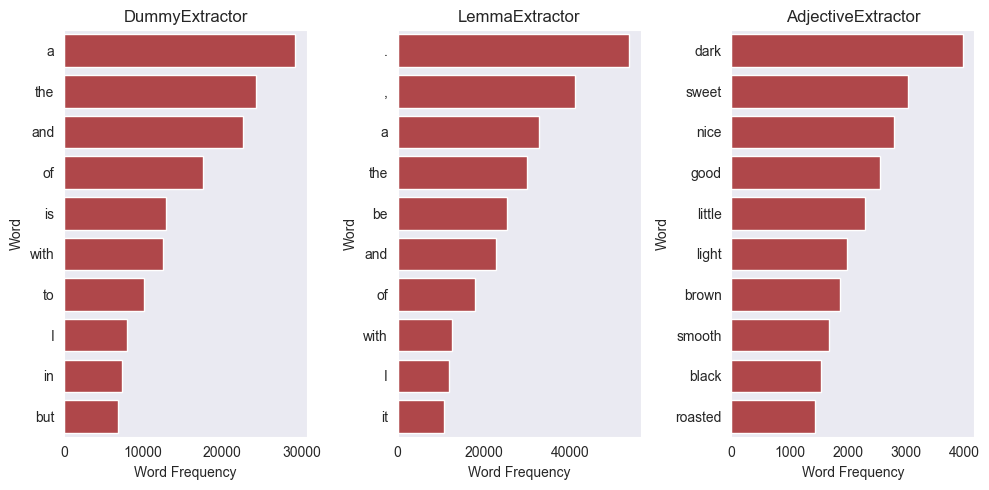

In [28]:
# We map the list of docs to the list of preprocessed strings
extracted_reviews = [extractor.transform(processed_reviews) for extractor in extractor_models]
frequencies = [utils.get_word_frequency(text) for text in extracted_reviews]

# Plot the word frequency of top-10 words for each extractor
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for ax, freq, extractor in zip(axes, frequencies, extractor_models):
    sns.barplot(x='frequency', y='word', data=freq.head(10), ax=ax)
    ax.set_title(extractor.name)
    ax.set_xlabel('Word Frequency')
    ax.set_ylabel('Word')

plt.tight_layout()

In summary, each of the extractors works as expected. Given the manual inspection of the extraction process, we hypothesise that the `AdjectiveExtractor` is the most suitable one for our task because the adjectives are most related to the taste of a beer. Thus, numerically representing only the subset of adjectives is going to be the closest proxy to an embedding of the beer's taste.

### Embedders

We need an embedding module to turn the extracted information from the reviews into a numeric representation. Let's go over how each one works.

- CountEmbeddors uses sklearn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Count vectorisation simply assigns each word in the vocabulary to a variable in the feature vector, and the values are the counts of each word. 

- TFIDF is similar to CountVectorizer, but also multiplies by an 'inverse document frequency' term. This weights a word in the vocabular by how frequently it appears in the corpus. Very common words are penalised, and rarer words are given more weight. This also uses sklearn's [TFIDFVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). This is done using the following formula:

$$w_{i,j} = tf_{i,j} \times \frac{N}{df_i}$$

where $w_{i,j}$ denotes the TFIDF of the $i$ th term in review $j$, $tf_{i,j}$ is the 'term frequency' (the count vectorization) of term $i$ in review $j$, $N$ is the total number of reviews and $df_i$ is the 'document frequency' of term $i$ i.e. the number of documents in which $i$ appears. This second half of the equation corresponds to the 'inverse document frequency' (IDF) of TFIDF.

- BERTEmbeddor uses `bert-base-uncased` [from HuggingFace](https://huggingface.co/bert-base-uncased). BERT is a bidirectional encoder-only transformer. There are many options for extracting embeddings from the model since there are 12 layers, and an embbedding for each token input. Currently, the implementation takes the penultimate hidden state of the model and takes the mean across all tokens in the input (see [this guide](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)).

- SentenceTransformerEmbeddor uses the recommended `all-MiniLM-L6-v2` model from the `sentence-transformers` [library]((https://www.sbert.net/docs/pretrained_models.html)). These models take outputs from BERT, conduct pooling similar to above (e.g. by default, mean of last layer), and are trained on various sentence-related NLP problems using [Siamese networks](https://towardsdatascience.com/a-friendly-introduction-to-siamese-networks-85ab17522942).

Let's initialize the embedder models and run them first on some dummy reviews and then a small sample of the actual reviews.

In [29]:
# Initalise embedders
embedding_models: list[embedders.EmbedderBase] = [
    embedders.CountEmbedder(),
    embedders.TfidfEmbedder(),
    embedders.BertEmbedder(),
    embedders.SentenceTransformerEmbedder(),
]

First, we compute the cosine similary between the first sentence and each subsequent sentence for each of the embedding models.

In [30]:
# Create a dataframe with some sample reviews
embedder_demo = pd.DataFrame(
    {
        "text": [
            "The beer is nice, with sweet nutty flavours",
            "This is a very different sentence",
            "Not sweet enough. I like my beer sweet. ",
            "Not sweet at all. Terrible beer. ",
            "Not sweet at all. But I like bitter beers so it is a nice beer. ",
            "Piss yellow beer",
            "Sweet beer"
        ]
    }
)

# Initialise results dataframe
results = pd.DataFrame(
    index=[model.name for model in embedding_models], 
    columns=[f"Similarity {i}" for i in range(1, len(embedder_demo))]
)

# Compute the similarity between the first and the nth sentence
for i in range(1, len(embedder_demo)):
    for model in embedding_models:
        similarity = utils.compute_similarity(model, embedder_demo["text"][0], embedder_demo["text"][i])
        results.loc[model.name, f"Similarity {i}"] = similarity

print("Similarity between first and nth sentence:")
results.head()

Similarity between first and nth sentence:


,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Similarity 6
CountEmbedder,0.158114,0.353553,0.288675,0.392232,0.204124,0.5
TfidfEmbedder,0.087044,0.224413,0.170776,0.248458,0.116718,0.379978
BertEmbedder,0.617567,0.79183,0.791252,0.828123,0.721489,0.776372
SentenceTransformerEmbedder,0.094767,0.667616,0.69976,0.718871,0.334227,0.650784


Here we can see the obvious pitfall of using CountVectorizer and TFIDF - they lose all context. Sentences 3 and 4 would ideally have the lowest similairty with sentence 1 since they are opposite in meaning. However, these samples all use the same words which Count and TFIDF interpret as therefore being similar. If, during the pipeline, we were to group beers by some measure that affects their sweetness, then in order to confirm out hypothesis we would like to see an increase of similarity inside each group, but we may lower similarity due to negations.

However, BERT and SentenceTransformers are not necessarily better. The values are far less interpretable, with sentence embeddor falling for a similar negation trap since similarities 3 and 4 are higher than 7. Interestingly, SentenceTransformer was far better than BERT at differentiating between sentences on different topic matters (similarity 2). BERT's scores are all broadly similar, and roughly gets the order in line what we might expect, but we have little faith that this translates any better than sentence transformer to the real reviews since these little samples play into BERT's context-aware strengths.

However, for now, we will try to make conclusions using tf-idf. It is the most interpretable (we can get out the most impactful words at the end), and so long as there are enough reviews that are long enough, we should see a meaningful vocabulary emerge. If the tfidf embeddings seem to be limiting us in the future, we can experiment with other methods.

Now let's try with some real sample reviews.

In [31]:
# Create a dataframe with some sample reviews
embedder_sample = pd.DataFrame({ "text": reviews.sample(4, random_state=0).review.text.values.tolist() })

# Initialise results dataframe
results = pd.DataFrame(
    index=[model.name for model in embedding_models], 
    columns=[f"Similarity {i}" for i in range(1, len(embedder_sample))]
)

# Compute the similarity between the first and the nth sentence
for i in range(1, len(embedder_sample)):
    for model in embedding_models:
        similarity = utils.compute_similarity(model, embedder_sample["text"][0], embedder_sample["text"][i])
        results.loc[model.name, f"Similarity {i}"] = similarity

print("Similarity between first and nth sentence:")
results.head()

Similarity between first and nth sentence:


,Similarity 1,Similarity 2,Similarity 3
CountEmbedder,0.301358,0.324482,0.296816
TfidfEmbedder,0.184997,0.222741,0.181423
BertEmbedder,0.928967,0.89636,0.941803
SentenceTransformerEmbedder,0.569074,0.543028,0.536188


Unsurprisinlgy, Count and TFIDF agree on ordering of similarity. However, BERT and SentenceTransformer disagree both with this ordering and each other. 
BERT is the less 'sure', with very high and close values, as in the previous example.

Reading the reviews, it's very hard to define what the ordering *should* be, therefore it is hard to define which embedder has done a better job in this sample. Further investigation will be carried out for P3.

### Consensus Clustering

The final step in the pipeline is to compute the consensus scores for a set of beer reviews. These are implemented as child classes of the `consensus.ConsensusBase` class. Currently, we have implemented the following consensus functions:

- `CosineSimilarity`: Computes the pairwise cosine similarity between all reviews in a set of reviews. The consensus score is the mean of all pairwise cosine similarities.

In [32]:
# Initialise the consensus models
consensus_models: list[consensus.ConsensusBase] = [
    consensus.CosineSimilarity(),
]

## Pipeline

---

We can bring the previous steps together into a `pipeline.TextAnalysis` objec that exposes a `transform` method which brings together all of the previous functionality.

We can now easily pass in a group of reviews and obtain a consensus score.

In [33]:
# Chosen extractor, embedder and consensus model
adjective_extractor = extractors.AdjectiveExtractor()
tfidf_embedder = embedders.TfidfEmbedder()
cosine_consensus = consensus.CosineSimilarity()

# Combine into pipeline
pipe = pipeline.TextAnalysis(adjective_extractor, tfidf_embedder, cosine_consensus)

In [34]:
# Overall consensus score
overall_consensus = pipe.transform(reviews.review.docs)

print(f"Overall Consensus: {overall_consensus}")

Overall Consensus: 0.06186846979687751


In [35]:
# Consensus within beer style
consensus_scores_per_beer_style = reviews.groupby(by=("beer", "style")).apply(lambda x: pipe.transform(x.review.docs))

# Consensus within brewery
consensus_scores_per_brewery = reviews.groupby(by=("brewery", "id")).apply(lambda x: pipe.transform(x.review.docs))

# Consensus within beer
consensus_scores_per_beer = reviews.groupby(by=("beer", "id")).apply(lambda x: pipe.transform(x.review.docs))

In [36]:
print(f"Consensus score per beer style: {consensus_scores_per_beer_style.mean()}")
print(f"Consensus score per brewery: {consensus_scores_per_brewery.mean()}")
print(f"Consensus score per beer: {consensus_scores_per_beer.mean()}")

Consensus score per beer style: 0.0733874700271136
Consensus score per brewery: 0.06991285303919346
Consensus score per beer: 0.0763424682145174


While the consensus score does not change significantly, the consensus does increase for all 3 sub-groupings (style, brewery and beer). This is promising for confirming our hypothesis that language used differs between beer types.

**Next Steps**

This notebook has shown that our pipeline is working as expected. The immediate next steps will be to run the analysis on the full dataset. Next, we have to quantify the certainity in the deviation of the consensus score that we observe between the different groupings and investigate the reasons behind this.

For the further analysis, there are many more avenues which we can explore, including groupings by other variables, interpretability of the language use (through TFIDF) and combination with an additional dataset of critics' reviews.